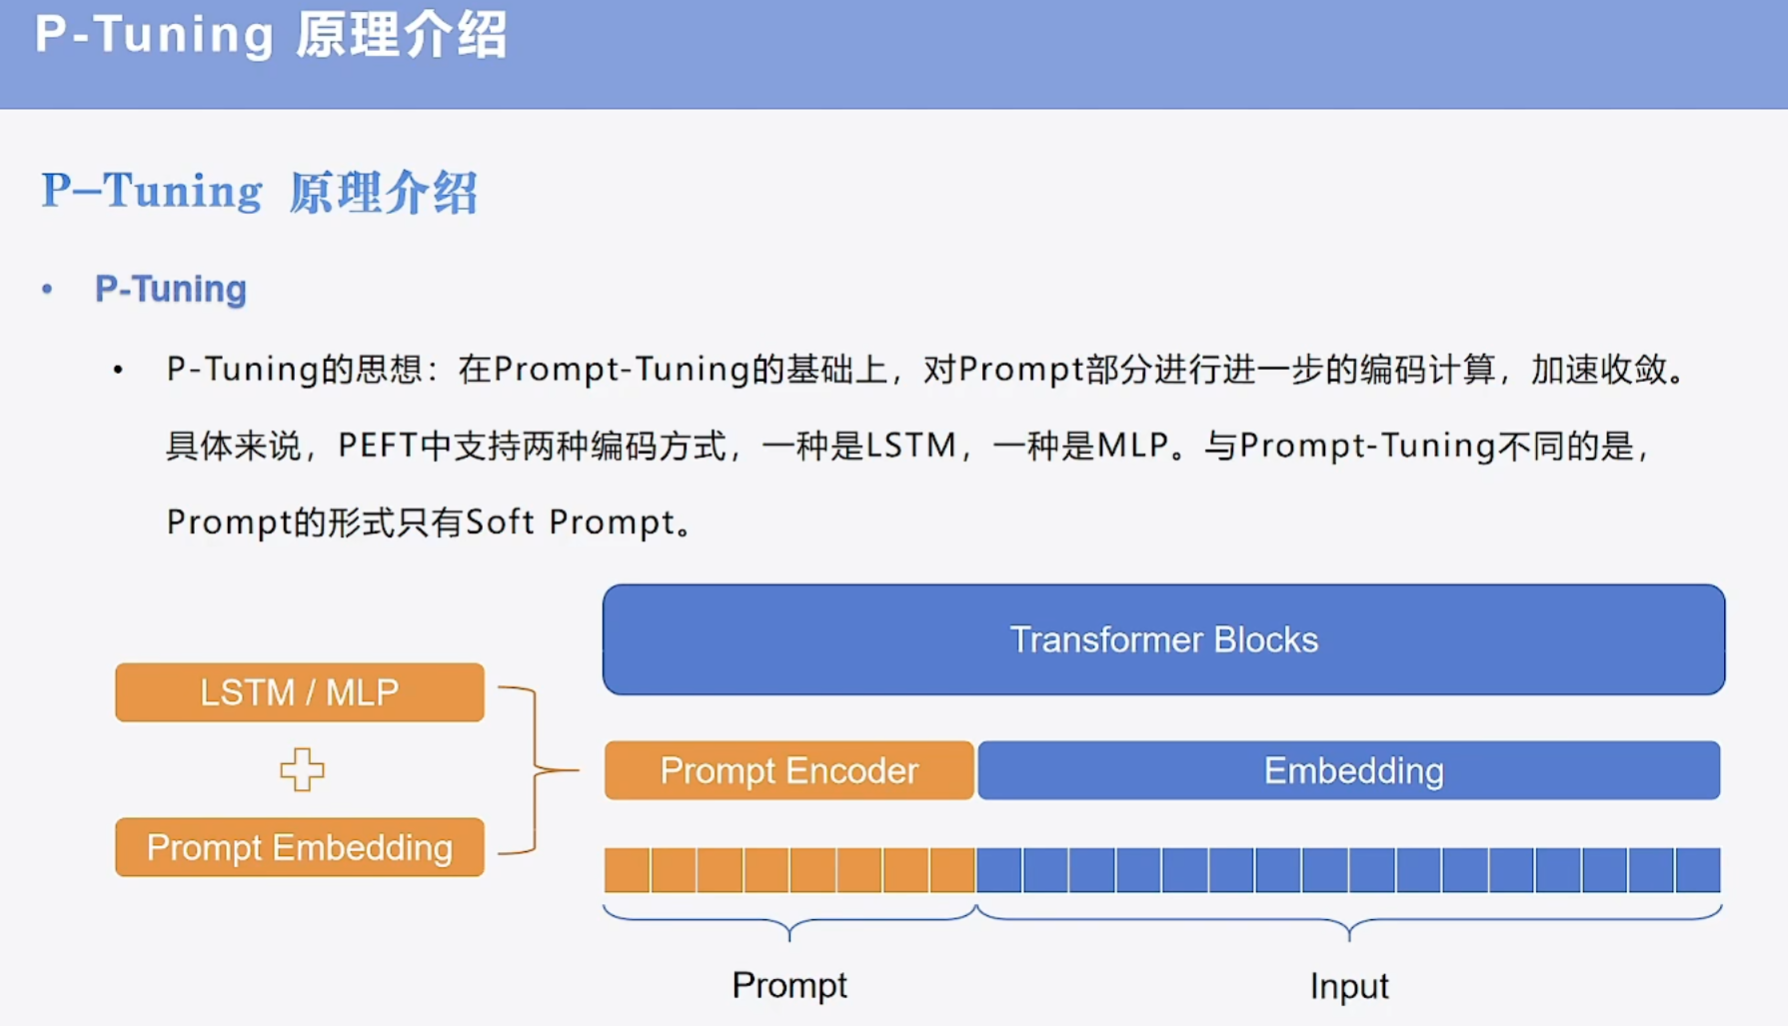

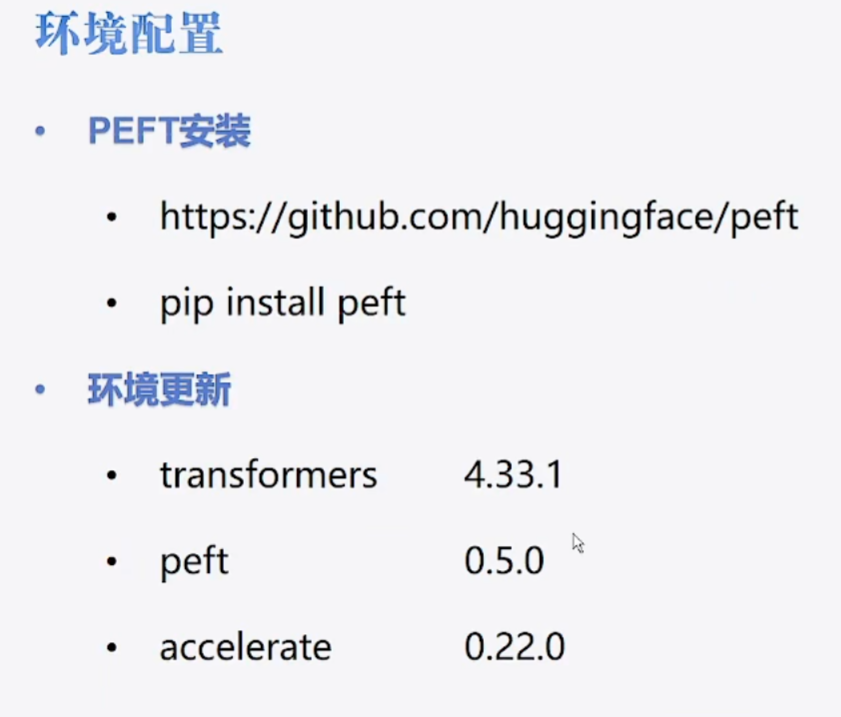

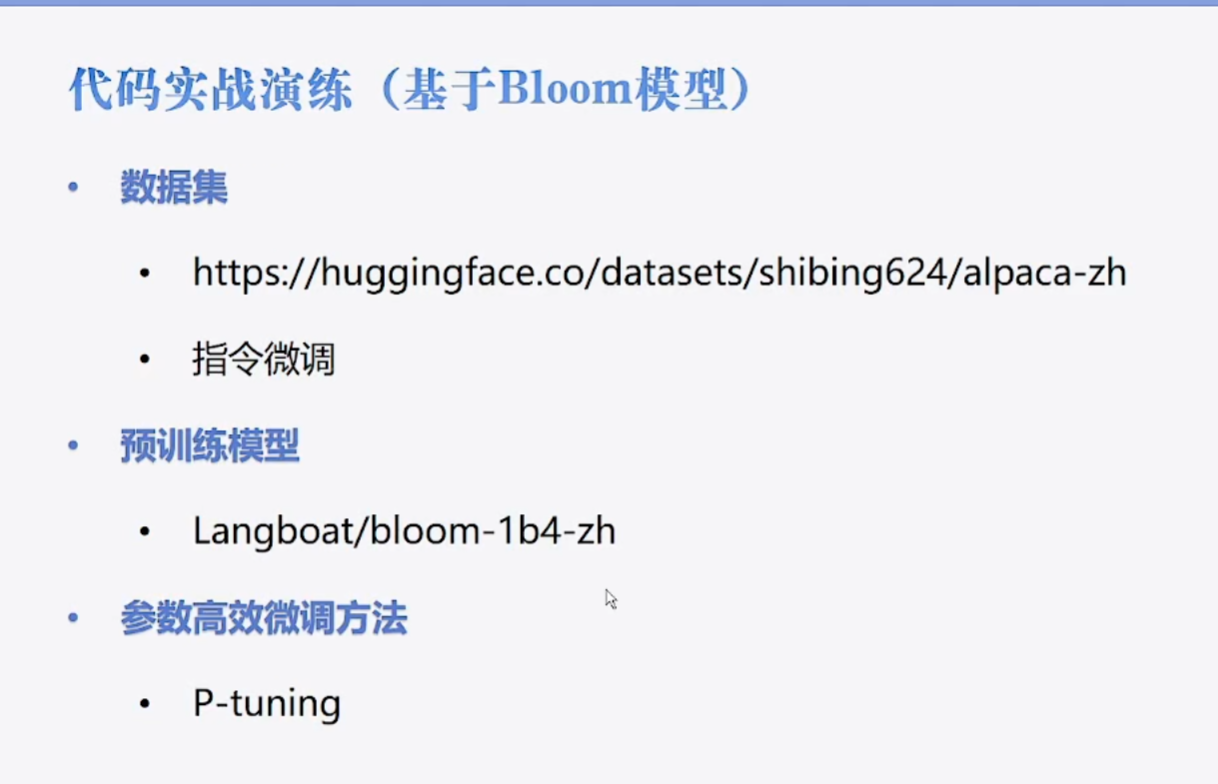

In [2]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [ ]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [6]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [7]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True)

# p-tuning

### Step1 配置文件

In [8]:
from peft import PromptEncoderConfig, TaskType, get_peft_model,PromptEncoderReparameterizationType
# PromptEncoderConfig是模型参数的配置
# TaskType是任务类型，这里选择causal_lm，表示causal language modeling任务
# get_peft_model是获取peft模型的方法，参数是模型和配置
# PromptEncoderReparameterizationType参数都是可选的，例如：
# PromptEncoderReparameterizationType.LORA表示使用Lora方法进行参数重parameterization
# PromptEncoderReparameterizationType.ADAPTER表示使用Adapter方法进行参数重parameterization
# PromptEncoderReparameterizationType.PROMPT_TUNING表示使用Prompt Tuning方法进行参数重parameterization
# PromptEncoderReparameterizationType.P_TUNING表示使用P-Tuning方法进行参数重parameterization


In [9]:
config=PromptEncoderConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10,
                           encoder_reparameterization_type=PromptEncoderReparameterizationType.LSTM,  # 可以调节编码器类型
                           encoder_dropout=0.1,  # 可以调节dropout
                           encoder_num_layers=1,  # 可以调节编码器层数
                           encoder_hidden_size=1024,  # 可以调节编码器隐藏层维度

)
config

PromptEncoderConfig(peft_type=<PeftType.P_TUNING: 'P_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=10, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, encoder_reparameterization_type=<PromptEncoderReparameterizationType.LSTM: 'LSTM'>, encoder_hidden_size=1024, encoder_num_layers=1, encoder_dropout=0.1)

### Step2 创建模型

In [10]:
model=get_peft_model(model,config)
model

D:\Environment\Python\python3.10\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


PeftModelForCausalLM(
  (base_model): BloomForCausalLM(
    (transformer): BloomModel(
      (word_embeddings): Embedding(46145, 2048)
      (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (h): ModuleList(
        (0-23): 24 x BloomBlock(
          (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (self_attention): BloomAttention(
            (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
            (dense): Linear(in_features=2048, out_features=2048, bias=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
          )
          (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (mlp): BloomMLP(
            (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
            (gelu_impl): BloomGelu()
            (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          )
        )
      )

In [11]:
model.print_trainable_parameters()

trainable params: 33,595,392 || all params: 1,336,707,072 || trainable%: 2.5133


-----------------------

In [13]:
args = TrainingArguments(
    output_dir="./p-tuning",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [14]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

In [15]:
trainer.train()

  0%|          | 0/3357 [00:00<?, ?it/s]

{'loss': 2.9686, 'grad_norm': 2.474106788635254, 'learning_rate': 4.985105749180816e-05, 'epoch': 0.0}
{'loss': 2.9036, 'grad_norm': 3.489985466003418, 'learning_rate': 4.9702114983616324e-05, 'epoch': 0.01}
{'loss': 2.6963, 'grad_norm': 1.8157727718353271, 'learning_rate': 4.9553172475424484e-05, 'epoch': 0.01}
{'loss': 2.6402, 'grad_norm': 2.8992702960968018, 'learning_rate': 4.940422996723265e-05, 'epoch': 0.01}
{'loss': 2.6064, 'grad_norm': 1.941860556602478, 'learning_rate': 4.925528745904081e-05, 'epoch': 0.01}
{'loss': 2.6332, 'grad_norm': 2.6481845378875732, 'learning_rate': 4.910634495084897e-05, 'epoch': 0.02}
{'loss': 2.4587, 'grad_norm': 2.019658327102661, 'learning_rate': 4.895740244265713e-05, 'epoch': 0.02}
{'loss': 2.5255, 'grad_norm': 1.6505461931228638, 'learning_rate': 4.88084599344653e-05, 'epoch': 0.02}
{'loss': 2.4062, 'grad_norm': 2.8512628078460693, 'learning_rate': 4.865951742627346e-05, 'epoch': 0.03}
{'loss': 2.412, 'grad_norm': 1.2704036235809326, 'learning_

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.3246, 'grad_norm': 2.2282326221466064, 'learning_rate': 4.240393208221627e-05, 'epoch': 0.15}
{'loss': 2.5408, 'grad_norm': 1.109097957611084, 'learning_rate': 4.225498957402443e-05, 'epoch': 0.15}
{'loss': 2.3631, 'grad_norm': 2.0059032440185547, 'learning_rate': 4.2106047065832595e-05, 'epoch': 0.16}
{'loss': 2.4064, 'grad_norm': 2.6246602535247803, 'learning_rate': 4.1957104557640756e-05, 'epoch': 0.16}
{'loss': 2.3738, 'grad_norm': 1.426613688468933, 'learning_rate': 4.180816204944891e-05, 'epoch': 0.16}
{'loss': 2.3387, 'grad_norm': 2.003596067428589, 'learning_rate': 4.165921954125708e-05, 'epoch': 0.17}
{'loss': 2.4225, 'grad_norm': 1.2150931358337402, 'learning_rate': 4.151027703306524e-05, 'epoch': 0.17}
{'loss': 2.4881, 'grad_norm': 3.6863741874694824, 'learning_rate': 4.1361334524873405e-05, 'epoch': 0.17}
{'loss': 2.3652, 'grad_norm': 1.2567144632339478, 'learning_rate': 4.121239201668156e-05, 'epoch': 0.18}
{'loss': 2.3193, 'grad_norm': 1.5200167894363403, 'lear

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.277, 'grad_norm': 1.530306100845337, 'learning_rate': 3.495680667262437e-05, 'epoch': 0.3}
{'loss': 2.3318, 'grad_norm': 1.4103336334228516, 'learning_rate': 3.480786416443253e-05, 'epoch': 0.3}
{'loss': 2.3579, 'grad_norm': 0.9839389324188232, 'learning_rate': 3.465892165624069e-05, 'epoch': 0.31}
{'loss': 2.3475, 'grad_norm': 1.104661464691162, 'learning_rate': 3.450997914804885e-05, 'epoch': 0.31}
{'loss': 2.224, 'grad_norm': 1.43620765209198, 'learning_rate': 3.436103663985702e-05, 'epoch': 0.31}
{'loss': 2.3675, 'grad_norm': 1.3871333599090576, 'learning_rate': 3.421209413166518e-05, 'epoch': 0.32}
{'loss': 2.3347, 'grad_norm': 3.638164520263672, 'learning_rate': 3.406315162347334e-05, 'epoch': 0.32}
{'loss': 2.4627, 'grad_norm': 1.1719523668289185, 'learning_rate': 3.39142091152815e-05, 'epoch': 0.32}
{'loss': 2.2802, 'grad_norm': 2.925194263458252, 'learning_rate': 3.376526660708966e-05, 'epoch': 0.32}
{'loss': 2.2375, 'grad_norm': 1.1415656805038452, 'learning_rate':

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.3623, 'grad_norm': 2.0046489238739014, 'learning_rate': 2.750968126303247e-05, 'epoch': 0.45}
{'loss': 2.3212, 'grad_norm': 1.5734572410583496, 'learning_rate': 2.7360738754840632e-05, 'epoch': 0.45}
{'loss': 2.4413, 'grad_norm': 0.8488699793815613, 'learning_rate': 2.7211796246648796e-05, 'epoch': 0.46}
{'loss': 2.3575, 'grad_norm': 0.9178283214569092, 'learning_rate': 2.7062853738456957e-05, 'epoch': 0.46}
{'loss': 2.4448, 'grad_norm': 1.794447422027588, 'learning_rate': 2.691391123026512e-05, 'epoch': 0.46}
{'loss': 2.3189, 'grad_norm': 0.7478679418563843, 'learning_rate': 2.676496872207328e-05, 'epoch': 0.46}
{'loss': 2.2326, 'grad_norm': 1.3349900245666504, 'learning_rate': 2.6616026213881445e-05, 'epoch': 0.47}
{'loss': 2.1097, 'grad_norm': 1.4596233367919922, 'learning_rate': 2.6467083705689606e-05, 'epoch': 0.47}
{'loss': 2.2797, 'grad_norm': 0.9997726082801819, 'learning_rate': 2.631814119749777e-05, 'epoch': 0.47}
{'loss': 2.3992, 'grad_norm': 0.9822179675102234, '

D:\Environment\Python\python3.10\Lib\site-packages\peft\utils\other.py:619: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: b4856104-4f78-4db8-8821-265cef1f1f11)') - silently ignoring the lookup for the file config.json in Langboat/bloom-1b4-zh.
  warnings.warn(
D:\Environment\Python\python3.10\Lib\site-packages\peft\utils\save_and_load.py:218: UserWarning: Could not find a config file in Langboat/bloom-1b4-zh - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 2.2672, 'grad_norm': 2.273900032043457, 'learning_rate': 2.0062555853440572e-05, 'epoch': 0.6}
{'loss': 2.2514, 'grad_norm': 1.489320158958435, 'learning_rate': 1.9913613345248736e-05, 'epoch': 0.6}
{'loss': 2.3509, 'grad_norm': 1.1550010442733765, 'learning_rate': 1.9764670837056897e-05, 'epoch': 0.6}
{'loss': 2.182, 'grad_norm': 0.9790744185447693, 'learning_rate': 1.961572832886506e-05, 'epoch': 0.61}
{'loss': 2.3729, 'grad_norm': 1.5721039772033691, 'learning_rate': 1.946678582067322e-05, 'epoch': 0.61}
{'loss': 2.2968, 'grad_norm': 1.689253330230713, 'learning_rate': 1.9317843312481382e-05, 'epoch': 0.61}
{'loss': 2.1733, 'grad_norm': 1.4327870607376099, 'learning_rate': 1.9168900804289542e-05, 'epoch': 0.62}
{'loss': 2.2549, 'grad_norm': 1.4857007265090942, 'learning_rate': 1.9019958296097706e-05, 'epoch': 0.62}
{'loss': 2.224, 'grad_norm': 1.6080564260482788, 'learning_rate': 1.8871015787905867e-05, 'epoch': 0.62}
{'loss': 2.2861, 'grad_norm': 1.5188671350479126, 'learn

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.2658, 'grad_norm': 4.708925247192383, 'learning_rate': 1.2615430443848674e-05, 'epoch': 0.75}
{'loss': 2.2325, 'grad_norm': 3.5175931453704834, 'learning_rate': 1.2466487935656837e-05, 'epoch': 0.75}
{'loss': 2.3407, 'grad_norm': 1.6793020963668823, 'learning_rate': 1.2317545427464999e-05, 'epoch': 0.75}
{'loss': 2.3564, 'grad_norm': 1.546735405921936, 'learning_rate': 1.2168602919273161e-05, 'epoch': 0.76}
{'loss': 2.2668, 'grad_norm': 1.615194320678711, 'learning_rate': 1.2019660411081324e-05, 'epoch': 0.76}
{'loss': 2.2563, 'grad_norm': 1.169028639793396, 'learning_rate': 1.1870717902889484e-05, 'epoch': 0.76}
{'loss': 2.3192, 'grad_norm': 9.514300346374512, 'learning_rate': 1.1721775394697646e-05, 'epoch': 0.77}
{'loss': 2.397, 'grad_norm': 1.403085708618164, 'learning_rate': 1.1572832886505809e-05, 'epoch': 0.77}
{'loss': 2.4577, 'grad_norm': 2.6981194019317627, 'learning_rate': 1.1423890378313971e-05, 'epoch': 0.77}
{'loss': 2.3272, 'grad_norm': 2.3620691299438477, 'le

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.2385, 'grad_norm': 1.6616265773773193, 'learning_rate': 5.168305034256777e-06, 'epoch': 0.9}
{'loss': 2.2885, 'grad_norm': 2.0086493492126465, 'learning_rate': 5.019362526064939e-06, 'epoch': 0.9}
{'loss': 2.3578, 'grad_norm': 2.4259512424468994, 'learning_rate': 4.870420017873101e-06, 'epoch': 0.9}
{'loss': 2.2248, 'grad_norm': 1.704410195350647, 'learning_rate': 4.721477509681263e-06, 'epoch': 0.91}
{'loss': 2.318, 'grad_norm': 1.6169861555099487, 'learning_rate': 4.572535001489425e-06, 'epoch': 0.91}
{'loss': 2.264, 'grad_norm': 1.4764370918273926, 'learning_rate': 4.423592493297587e-06, 'epoch': 0.91}
{'loss': 2.4064, 'grad_norm': 1.2307981252670288, 'learning_rate': 4.274649985105749e-06, 'epoch': 0.91}
{'loss': 2.3596, 'grad_norm': 1.2615288496017456, 'learning_rate': 4.125707476913911e-06, 'epoch': 0.92}
{'loss': 2.3669, 'grad_norm': 1.726419448852539, 'learning_rate': 3.976764968722073e-06, 'epoch': 0.92}
{'loss': 2.2243, 'grad_norm': 1.5849958658218384, 'learning_ra

TrainOutput(global_step=3357, training_loss=2.3410489676358766, metrics={'train_runtime': 2951.4175, 'train_samples_per_second': 9.1, 'train_steps_per_second': 1.137, 'total_flos': 1.476411489067008e+16, 'train_loss': 2.3410489676358766, 'epoch': 0.9999255342914588})